# Multilayer perceptron

A multilayer perceptron, i.e., a neural network, can be used as a classical machine learning classifier. Here, it is meant to serve as a baseline for later comparison with the three GNNs. Because it is only a simple neural network and not a GNN, it does not take the graph structure into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import NodeClassificationDataset

import json
import os
import os.path as osp
import time

from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation accuracy is:', df_best[variable].unique()[0])

In [7]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [8]:
def visualize(h, color):
    """
    Visualize the learned embeddings after reducing them to two dimensions.
    """
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    scatter = plt.scatter(z[:, 0], z[:, 1], s=10, c=color, cmap="Set2")
    handles, _ = scatter.legend_elements(prop='colors')
    handles = [handles[i] for i in [2,3,1,0]]
    labels = ['S1', 'S2', 'S3', 'S4']
    return handles, labels

In [9]:
def plot_embeddings(df, filename, save):
    """
    Plot the two-dimensional embeddings in a 5 times 2 plot.
    """
    torch_geometric.seed_everything(12345) 
    
    sns.set_style("whitegrid") 

    plt.figure(figsize=(8, 12))

    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    out_mlp = [out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10]
    y = [y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10]
    for i, seed in enumerate(seeds):
        out_mlp[i] = df['embeddings'][i] 
        y[i] = df['y'][i] 
        axes[i] = plt.subplot(5,2,i+1)
        handles, labels = visualize(out_mlp[i], color=y[i])
        axes[i].set_title(f"Run {i+1}: seed {seed}")

    for ax in axes:
        ax.set(xlabel='Dimension 1', ylabel='Dimension 2')
        
    plt.tight_layout() 
        
    legend = plt.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(-0.1, -0.3), frameon=True, title='segment',
                        edgecolor='black')

    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

In [31]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch implementation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) of a linear layer `Linear`. The article [What are Hyperparameters ? and How to tune the Hyperparameters in a Deep Neural Network?](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a) gives a good overview of hyperparameter tuning for MLPs.

With MLPs, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the MLP. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting, given our relatively small number of 229 nodes. We now perform the hyperparameter tuning using loops.

In [11]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [12]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_prob):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=dropout_prob, training=self.training)
        x = self.lin2(x)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()  
    out_train=model(data.x[data.train_mask])
    loss_train = criterion(out_train, data.y[data.train_mask])
    loss_train.backward()  
    optimizer.step()  
    model.eval()
    out_val = model(data.x[data.val_mask])
    loss_val = criterion(out_val, data.y[data.val_mask])
    out_test = model(data.x[data.test_mask])
    loss_test = criterion(out_test, data.y[data.test_mask])
    return loss_train, loss_val, loss_test, out_train, out_val, out_test


def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) 
    return train_acc, val_acc, test_acc 

In [ ]:
start_time = time.time()

mlp_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_accs', 'val_accs', 
                                      'test_accs', 'best_train_losses', 'best_val_losses', 'best_test_losses', 
                                      'best_train_accs', 'best_val_accs', 'best_test_accs', 'mean_best_train_loss', 
                                      'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_acc', 'mean_best_val_acc', 
                                      'mean_best_test_acc', 'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 
                                      'std_best_train_acc', 'std_best_val_acc', 'std_best_test_acc'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [8, 16, 32]:
    for dropout_prob in [0.1, 0.3, 0.5, 0.7]:
        for learning_rate in [0.001, 0.01, 0.1]:
            for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4, 5e-5, 5e-6]:
                for patience in [3, 5, 10]:
                
                    # Hyperparamter tuning

                    print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')
                    
                    parameter_dict = dict({'hidden_channels': hidden_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                    loss_dict = dict()
                    val_loss_dict = dict()
                    test_loss_dict = dict()
                    train_acc_dict = dict()
                    val_acc_dict = dict()
                    test_acc_dict = dict()

                    best_train_loss_dict = dict()
                    best_val_loss_dict = dict()
                    best_test_loss_dict = dict()
                    best_train_acc_dict = dict()
                    best_val_acc_dict = dict()
                    best_test_acc_dict = dict()

                    for i, seed in enumerate(seeds): 

                        torch_geometric.seed_everything(seed)

                        dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
                        data = dataset[0]
                        
                        model = MLP(hidden_channels = hidden_channels, dropout_prob = dropout_prob)

                        criterion = torch.nn.CrossEntropyLoss() 
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  
                        
                        loss_list = []
                        val_loss_list = []
                        test_loss_list = []
                        train_acc_list = []
                        val_acc_list = []
                        test_acc_list = []

                        last_loss = 100
                        patience = patience 
                        trigger_times = 0

                        print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                        for epoch in range(1, 101):
                            loss, val_loss, test_loss, out_train, out_val, out_test = train() 
                            train_acc, val_acc, test_acc = test() 
                            loss_list += [loss.item()]
                            val_loss_list += [val_loss.item()]
                            test_loss_list += [test_loss.item()]
                            train_acc_list += [train_acc]
                            val_acc_list += [val_acc]
                            test_acc_list += [test_acc]

                            current_val_loss = val_loss

                            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

                            if current_val_loss <= last_loss:
                                current_best_train_loss = loss.item()
                                current_best_val_loss = current_val_loss.item()
                                current_best_test_loss = test_loss.item()
                                current_best_train_acc = train_acc
                                current_best_val_acc = val_acc
                                current_best_test_acc = test_acc

                                trigger_times = 0
                                print('Trigger times: 0')

                                last_loss = current_val_loss

                            else: 
                                trigger_times += 1
                                print('Trigger times:', trigger_times)

                                if trigger_times >= patience:
                                    print('Early stopping!')
                                    break

                        loss_dict.update({f"{i+1}": loss_list}) 
                        val_loss_dict.update({f"{i+1}": val_loss_list}) 
                        test_loss_dict.update({f"{i+1}": test_loss_list}) 
                        train_acc_dict.update({f"{i+1}": train_acc_list}) 
                        val_acc_dict.update({f"{i+1}": val_acc_list}) 
                        test_acc_dict.update({f"{i+1}": test_acc_list}) 

                        best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                        best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                        best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                        best_train_acc_dict.update({f"{i+1}": current_best_train_acc}) 
                        best_val_acc_dict.update({f"{i+1}": current_best_val_acc})
                        best_test_acc_dict.update({f"{i+1}": current_best_test_acc}) 

                        print(current_best_val_loss)

                    data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                    'test_losses': test_loss_dict, 'train_accs': train_acc_dict, 'val_accs': val_acc_dict, 
                                    'test_accs': test_acc_dict, 'best_train_losses': best_train_loss_dict, 
                                    'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                    'best_train_accs': best_train_acc_dict, 'best_val_accs': best_val_acc_dict, 
                                    'best_test_accs': best_test_acc_dict, 
                                    'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                    'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                    'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                    'mean_best_train_acc': mean(best_train_acc_dict.values()), 
                                    'mean_best_val_acc': mean(best_val_acc_dict.values()), 
                                    'mean_best_test_acc': mean(best_test_acc_dict.values()),
                                    'std_best_train_loss': std(best_train_loss_dict.values()), 
                                    'std_best_val_loss': std(best_val_loss_dict.values()), 
                                    'std_best_test_loss': std(best_test_loss_dict.values()), 
                                    'std_best_train_acc': std(best_train_acc_dict.values()), 
                                    'std_best_val_acc': std(best_val_acc_dict.values()), 
                                    'std_best_test_acc': std(best_test_acc_dict.values())}]
                    df_concat = pd.DataFrame(data_concat)
                    mlp_results = pd.concat([mlp_results, df_concat], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to mlp_results.pkl")
mlp_results.to_pickle(f"{route0}/mlp_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [13]:
# Look at results
mlp_results = pd.read_pickle(f"{route0}/mlp_results.pkl") 
mlp_results

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
0,"{'hidden_channels': 8, 'dropout_prob': 0.1, 'l...","{'1': [1.4173197746276855, 1.4170267581939697,...","{'1': [1.3171426057815552, 1.3170475959777832,...","{'1': [1.3032687902450562, 1.303062081336975, ...","{'1': [0.225, 0.225, 0.225, 0.225, 0.225, 0.22...","{'1': [0.31666666666666665, 0.3166666666666666...","{'1': [0.34108527131782945, 0.3488372093023256...","{'1': 1.4148039817810059, '2': 1.4189965724945...","{'1': 1.3170015811920166, '2': 1.2992589473724...","{'1': 1.3028991222381592, '2': 1.3114787340164...",...,1.303684,0.2825,0.356667,0.368992,0.023525,0.011639,0.008436,0.079883,0.035901,0.052485
1,"{'hidden_channels': 8, 'dropout_prob': 0.1, 'l...","{'1': [1.4173197746276855, 1.4170267581939697,...","{'1': [1.3171426057815552, 1.3170475959777832,...","{'1': [1.3032687902450562, 1.303062081336975, ...","{'1': [0.225, 0.225, 0.225, 0.225, 0.225, 0.22...","{'1': [0.31666666666666665, 0.3166666666666666...","{'1': [0.34108527131782945, 0.3488372093023256...","{'1': 1.371191382408142, '2': 1.41899657249450...","{'1': 1.3087975978851318, '2': 1.2992589473724...","{'1': 1.295425534248352, '2': 1.31147873401641...",...,1.302937,0.2875,0.365000,0.382946,0.025152,0.011370,0.008796,0.077661,0.035316,0.064504
2,"{'hidden_channels': 8, 'dropout_prob': 0.1, 'l...","{'1': [1.4173197746276855, 1.4170267581939697,...","{'1': [1.3171426057815552, 1.3170475959777832,...","{'1': [1.3032687902450562, 1.303062081336975, ...","{'1': [0.225, 0.225, 0.225, 0.225, 0.225, 0.22...","{'1': [0.31666666666666665, 0.3166666666666666...","{'1': [0.34108527131782945, 0.3488372093023256...","{'1': 1.371191382408142, '2': 1.41899657249450...","{'1': 1.3087975978851318, '2': 1.2992589473724...","{'1': 1.295425534248352, '2': 1.31147873401641...",...,1.302823,0.2900,0.371667,0.388372,0.024484,0.011379,0.008761,0.075993,0.040859,0.060985
3,"{'hidden_channels': 8, 'dropout_prob': 0.1, 'l...","{'1': [1.4173197746276855, 1.4156395196914673,...","{'1': [1.315735936164856, 1.3142569065093994, ...","{'1': [1.3020071983337402, 1.3005539178848267,...","{'1': [0.225, 0.225, 0.225, 0.225, 0.25, 0.25,...","{'1': [0.31666666666666665, 0.3, 0.3, 0.333333...","{'1': [0.37209302325581395, 0.3875968992248062...","{'1': 1.0917911529541016, '2': 1.0567982196807...","{'1': 1.125110149383545, '2': 1.17766773700714...","{'1': 1.1334518194198608, '2': 1.1576893329620...",...,1.155454,0.8650,0.748333,0.737984,0.027906,0.025067,0.014912,0.059372,0.055503,0.065484
4,"{'hidden_channels': 8, 'dropout_prob': 0.1, 'l...","{'1': [1.4173197746276855, 1.4156395196914673,...","{'1': [1.315735936164856, 1.3142569065093994, ...","{'1': [1.3020071983337402, 1.3005539178848267,...","{'1': [0.225, 0.225, 0.225, 0.225, 0.25, 0.25,...","{'1': [0.31666666666666665, 0.3, 0.3, 0.333333...","{'1': [0.37209302325581395, 0.3875968992248062...","{'1': 1.0917911529541016, '2': 1.0567982196807...","{'1': 1.125110149383545, '2': 1.17766773700714...","{'1': 1.1334518194198608, '2': 1.1576893329620...",...,1.155454,0.8650,0.748333,0.737984,0.027906,0.025067,0.014912,0.059372,0.055503,0.065484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,"{'hidden_channels': 32, 'dropout_prob': 0.7, '...","{'1': [1.4209941625595093, 1.299399733543396, ...","{'1': [1.072726845741272, 1.141554355621338, 1...","{'1': [1.1121166944503784, 1.1133910417556763,...","{'1': [0.675, 0.85, 0.675, 0.75, 0.875, 0.95, ...","{'1': [0.7833333333333333, 0.6333333333333333,...","{'1': [0.7829457364341085, 0.7441860465116279,...","{'1': 0.5114942789077759, '2': 0.4536546766757...","{'1': 0.46986979246139526, '2': 0.437907963991...","{'1': 0.4266408383846283, '2': 0.5101600885391..

##  Best hyperparameter combination

In [14]:
filter_best_hyperparameters(mlp_results, 'mean_best_val_acc')

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
472,"{'hidden_channels': 32, 'dropout_prob': 0.1, '...","{'1': [1.399155616760254, 1.3797311782836914, ...","{'1': [1.1593188047409058, 1.1635241508483887,...","{'1': [1.2191922664642334, 1.1502430438995361,...","{'1': [0.275, 0.85, 0.675, 0.975, 0.95, 0.975,...","{'1': [0.36666666666666664, 0.5833333333333334...","{'1': [0.2713178294573643, 0.7131782945736435,...","{'1': 0.17696259915828705, '2': 0.138495683670...","{'1': 0.3539990484714508, '2': 0.3793939948081...","{'1': 0.36026814579963684, '2': 0.491608679294...",...,0.418278,0.985,0.863333,0.88062,0.051989,0.062776,0.040593,0.016583,0.045216,0.022786
473,"{'hidden_channels': 32, 'dropout_prob': 0.1, '...","{'1': [1.399155616760254, 1.3797311782836914, ...","{'1': [1.1593188047409058, 1.1635241508483887,...","{'1': [1.2191922664642334, 1.1502430438995361,...","{'1': [0.275, 0.85, 0.675, 0.975, 0.95, 0.975,...","{'1': [0.36666666666666664, 0.5833333333333334...","{'1': [0.2713178294573643, 0.7131782945736435,...","{'1': 0.17696259915828705, '2': 0.138495683670...","{'1': 0.3539990484714508, '2': 0.3793939948081...","{'1': 0.36026814579963684, '2': 0.491608679294...",...,0.418278,0.985,0.863333,0.88062,0.051989,0.062776,0.040593,0.016583,0.045216,0.022786


In [15]:
print_best_hyperparameters(mlp_results, 'mean_best_val_acc')

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 5}
	 {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10} 
The resulting validation accuracy is: 0.8633333333333333


We see that there are two hyperparameter combinations that lead to the highest mean best validation accuracy of 0.8633. These hyperparameter combinations differ only in their respective value of `patience`, where one has a value of 5 and the other has a value of 10. Apart from their equal values for the mean best validation accuracy, they also display identical values for the mean best training accuracy and the mean best test accuracy as well as for the standard deviations of the best training, validation and test accuracies. 

So, our best hyperparameter combinations are given by:

* hidden_channels = 32
* dropout_prob = 0.1
* learning_rate = 0.1
* weight_decay = 0.05
* patience = 5

and 

* hidden_channels = 32
* dropout_prob = 0.1
* learning_rate = 0.1
* weight_decay = 0.05
* patience = 10

They give a mean best training accuracy of 0.9850, where the mean best validation accuracy of 0.8633 and the mean best test accuracy of 0.8806 are a little lower. The standard deviation of the best training accuracies of 0.0166 is very low, where the standard deviations of the best validation accuracies and the best test accuracies are a bit higher, with values of 0.0452 and 0.0228, respectively.

## Visualizations

After having found the best hyperparameter combinations, we would now look to create some useful visualizations. Specifically, we would like to visualize the embeddings learned by the multilayer perceptron in the 10 runs for the best hyperparameter combinations and visualize the development of losses and accuracies in the training set, validation set and test set for the best hyperparameter combinations. For the former, we run the above code again 10 times for the best hyperparameter combinations and save the respective embeddings in the data frame `mlp_embeddings_1` and `mlp_embeddings_2`.

### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 5}

In [16]:
# Repeat 10 runs of best model

start_time = time.time()

mlp_embeddings_1 = pd.DataFrame(columns=['run', 'embeddings', 'y'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparamters
hidden_channels = 32
dropout_prob = 0.1
learning_rate = 0.1
weight_decay = 5e-2
patience = 5
                    
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed) 

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]
    
    model = MLP(hidden_channels=hidden_channels, dropout_prob=dropout_prob)

    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, out_train, out_val, out_test = train() 
        train_acc, val_acc, test_acc = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}') 

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_out_train = out_train
            current_best_out_val = out_val
            current_best_out_test = out_test
            current_best_train_acc = train_acc
            current_best_val_acc = val_acc
            current_best_test_acc = test_acc
            
            trigger_times = 0
            print('Trigger times: 0')
            
            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)
    
    embed = [{'run': i+1, 'embeddings': torch.cat((current_best_out_train, current_best_out_val, current_best_out_test), 0), 'y': data.y}]
    embed = pd.DataFrame(embed)
    mlp_embeddings_1 = pd.concat([mlp_embeddings_1, embed], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to mlp_embeddings_1.pkl")
mlp_embeddings_1.to_pickle(f"{route0}/mlp_embeddings_1.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 32, dropout_prob: 0.1, learning_rate: 0.1, weight_decay: 0.05, patience: 5}
Run 1 with seed 12345:
Epoch: 001, Train Loss: 1.3992, Val Loss: 1.1593, Test Loss: 1.2192, train acc: 0.2750, val acc: 0.3667, test acc: 0.2713
Trigger times: 0
Epoch: 002, Train Loss: 1.3797, Val Loss: 1.1635, Test Loss: 1.1502, train acc: 0.8500, val acc: 0.5833, test acc: 0.7132
Trigger times: 1
Epoch: 003, Train Loss: 1.0219, Val Loss: 1.1330, Test Loss: 1.0759, train acc: 0.6750, val acc: 0.4333, test acc: 0.4806
Trigger times: 0
Epoch: 004, Train Loss: 0.7357, Val Loss: 0.7087, Test Loss: 0.6605, train acc: 0.9750, val acc: 0.7333, test acc: 0.8605
Trigger times: 0
Epoch: 005, Train Loss: 0.4837, Val Loss: 0.5036, Test Loss: 0.5253, train acc: 0.9500, val acc: 0.7667, test acc: 0.8450
Trigger times: 0
Epoch: 006, Train Loss: 0.3511, Val Loss: 0.5122, Test Loss: 0.5037, train acc: 0.9750, val acc: 0.7833, test acc: 0.8527
Trigger times: 1
Epoch: 007, Train Loss: 0.

Processing...
Done!
Processing...
Done!
Processing...
Done!


Run 2 with seed 23456:
Epoch: 001, Train Loss: 1.4008, Val Loss: 1.2024, Test Loss: 1.1860, train acc: 0.5250, val acc: 0.6000, test acc: 0.6434
Trigger times: 0
Epoch: 002, Train Loss: 1.2308, Val Loss: 1.4429, Test Loss: 1.4220, train acc: 0.5250, val acc: 0.2167, test acc: 0.2481
Trigger times: 1
Epoch: 003, Train Loss: 0.9915, Val Loss: 0.8970, Test Loss: 0.8611, train acc: 0.9250, val acc: 0.6833, test acc: 0.7209
Trigger times: 0
Epoch: 004, Train Loss: 0.5784, Val Loss: 0.7024, Test Loss: 0.7199, train acc: 0.9750, val acc: 0.8000, test acc: 0.7984
Trigger times: 0
Epoch: 005, Train Loss: 0.4425, Val Loss: 0.5655, Test Loss: 0.5868, train acc: 0.9750, val acc: 0.8167, test acc: 0.8527
Trigger times: 0
Epoch: 006, Train Loss: 0.2704, Val Loss: 0.5609, Test Loss: 0.5556, train acc: 0.9500, val acc: 0.7833, test acc: 0.8527
Trigger times: 0
Epoch: 007, Train Loss: 0.1870, Val Loss: 0.4436, Test Loss: 0.5316, train acc: 1.0000, val acc: 0.8833, test acc: 0.8605
Trigger times: 0
Epoc

Processing...
Done!
Processing...
Done!



Trigger times: 0
Epoch: 005, Train Loss: 0.6337, Val Loss: 0.6650, Test Loss: 0.6100, train acc: 0.9500, val acc: 0.8167, test acc: 0.8527
Trigger times: 0
Epoch: 006, Train Loss: 0.4435, Val Loss: 0.6659, Test Loss: 0.5849, train acc: 0.9250, val acc: 0.8000, test acc: 0.8527
Trigger times: 1
Epoch: 007, Train Loss: 0.3490, Val Loss: 0.6612, Test Loss: 0.5344, train acc: 0.9250, val acc: 0.8167, test acc: 0.8527
Trigger times: 0
Epoch: 008, Train Loss: 0.2529, Val Loss: 0.5272, Test Loss: 0.4349, train acc: 0.9500, val acc: 0.8000, test acc: 0.8915
Trigger times: 0
Epoch: 009, Train Loss: 0.2593, Val Loss: 0.4640, Test Loss: 0.3908, train acc: 0.9500, val acc: 0.8167, test acc: 0.8837
Trigger times: 0
Epoch: 010, Train Loss: 0.1913, Val Loss: 0.4730, Test Loss: 0.4123, train acc: 0.9750, val acc: 0.8167, test acc: 0.8682
Trigger times: 1
Epoch: 011, Train Loss: 0.2791, Val Loss: 0.5021, Test Loss: 0.4516, train acc: 0.9500, val acc: 0.8000, test acc: 0.8837
Trigger times: 2
Epoch: 01

Processing...
Done!
Processing...
Done!



Epoch: 001, Train Loss: 1.4017, Val Loss: 1.2109, Test Loss: 1.1787, train acc: 0.5250, val acc: 0.4667, test acc: 0.5814
Trigger times: 0
Epoch: 002, Train Loss: 1.3287, Val Loss: 1.2257, Test Loss: 1.2226, train acc: 0.7500, val acc: 0.3500, test acc: 0.3566
Trigger times: 1
Epoch: 003, Train Loss: 1.0624, Val Loss: 1.1609, Test Loss: 1.1118, train acc: 0.7500, val acc: 0.4333, test acc: 0.4496
Trigger times: 0
Epoch: 004, Train Loss: 0.7481, Val Loss: 0.9685, Test Loss: 0.8633, train acc: 0.8250, val acc: 0.5333, test acc: 0.6279
Trigger times: 0
Epoch: 005, Train Loss: 0.5062, Val Loss: 0.7898, Test Loss: 0.6483, train acc: 0.9500, val acc: 0.7500, test acc: 0.7907
Trigger times: 0
Epoch: 006, Train Loss: 0.3947, Val Loss: 0.6960, Test Loss: 0.5126, train acc: 0.9500, val acc: 0.8167, test acc: 0.8682
Trigger times: 0
Epoch: 007, Train Loss: 0.2666, Val Loss: 0.6314, Test Loss: 0.4211, train acc: 0.9500, val acc: 0.8167, test acc: 0.8915
Trigger times: 0
Epoch: 008, Train Loss: 0.

Processing...
Done!
Processing...
Done!

Run 8 with seed 76543:
Epoch: 001, Train Loss: 1.3940, Val Loss: 1.1689, Test Loss: 1.1786, train acc: 0.4750, val acc: 0.5333, test acc: 0.5969
Trigger times: 0
Epoch: 002, Train Loss: 1.3042, Val Loss: 1.3585, Test Loss: 1.3431, train acc: 0.4750, val acc: 0.1167, test acc: 0.1938
Trigger times: 1
Epoch: 003, Train Loss: 1.0330, Val Loss: 1.0633, Test Loss: 1.0326, train acc: 0.6750, val acc: 0.4833, test acc: 0.4806
Trigger times: 0
Epoch: 004, Train Loss: 0.7956, Val Loss: 0.7832, Test Loss: 0.7597, train acc: 0.9250, val acc: 0.8000, test acc: 0.8372
Trigger times: 0
Epoch: 005, Train Loss: 0.5907, Val Loss: 0.7235, Test Loss: 0.6875, train acc: 0.9500, val acc: 0.7667, test acc: 0.8062
Trigger times: 0
Epoch: 006, Train Loss: 0.4694, Val Loss: 0.5616, Test Loss: 0.5146, train acc: 0.9500, val acc: 0.8500, test acc: 0.8760
Trigger times: 0
Epoch: 007, Train Loss: 0.2961, Val Loss: 0.5068, Test Loss: 0.4525, train acc: 0.9500, val acc: 0.8500, test acc: 0.8682
Trigger times: 0
Epoc


Processing...


Epoch: 008, Train Loss: 0.2306, Val Loss: 0.3839, Test Loss: 0.5560, train acc: 0.9500, val acc: 0.8500, test acc: 0.8140
Trigger times: 0
Epoch: 009, Train Loss: 0.2075, Val Loss: 0.3361, Test Loss: 0.4691, train acc: 0.9500, val acc: 0.8833, test acc: 0.8605
Trigger times: 0
Epoch: 010, Train Loss: 0.1850, Val Loss: 0.3290, Test Loss: 0.4245, train acc: 0.9750, val acc: 0.9333, test acc: 0.8915
Trigger times: 0
Epoch: 011, Train Loss: 0.1926, Val Loss: 0.3748, Test Loss: 0.5036, train acc: 0.9750, val acc: 0.9167, test acc: 0.8372
Trigger times: 1
Epoch: 012, Train Loss: 0.2263, Val Loss: 0.4201, Test Loss: 0.6247, train acc: 0.9500, val acc: 0.8500, test acc: 0.7674
Trigger times: 2
Epoch: 013, Train Loss: 0.2166, Val Loss: 0.4122, Test Loss: 0.5971, train acc: 1.0000, val acc: 0.8500, test acc: 0.7829
Trigger times: 3
Epoch: 014, Train Loss: 0.2522, Val Loss: 0.3912, Test Loss: 0.4955, train acc: 1.0000, val acc: 0.9333, test acc: 0.8760
Trigger times: 4
Epoch: 015, Train Loss: 0.2

Done!


In [17]:
# Look at embeddings
mlp_embeddings_1 = pd.read_pickle(f"{route0}/mlp_embeddings_1.pkl") 
mlp_embeddings_1

,run,embeddings,y
0,1,"[[tensor(-2.1645, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
1,2,"[[tensor(-1.3103, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
2,3,"[[tensor(-1.4452, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
3,4,"[[tensor(-1.7578, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
4,5,"[[tensor(-1.5499, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
5,6,"[[tensor(-1.5492, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
6,7,"[[tensor(-0.6828, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
7,8,"[[tensor(-0.3942, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
8,9,"[[tensor(-1.0132, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
9,10,"[[tensor(-1.6406, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."


To get a better impression of our model, let us look at a summary of our multilayer perceptron.

In [18]:
model

MLP(
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=4, bias=True)
)

In [19]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
         lin1.weight                   [32, 64]            2048
           lin1.bias                       [32]              32
         lin2.weight                    [4, 32]             128
           lin2.bias                        [4]               4
----------------------------------------------------------------
Total params: 2212
Trainable params: 2212
Non-trainable params: 0


### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10}

In [20]:
# Repeat 10 runs of best model

start_time = time.time()

mlp_embeddings_2 = pd.DataFrame(columns=['run', 'embeddings', 'y'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparamters
hidden_channels = 32
dropout_prob = 0.1
learning_rate = 0.1
weight_decay = 5e-2
patience = 10
                    
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed) 

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]
    
    model = MLP(hidden_channels=hidden_channels, dropout_prob=dropout_prob)

    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, out_train, out_val, out_test = train() 
        train_acc, val_acc, test_acc = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_out_train = out_train
            current_best_out_val = out_val
            current_best_out_test = out_test
            current_best_train_acc = train_acc
            current_best_val_acc = val_acc
            current_best_test_acc = test_acc
            
            trigger_times = 0
            print('Trigger times: 0')
            
            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break
                
    print(current_best_val_loss)
    
    embed = [{'run': i+1, 'embeddings': torch.cat((current_best_out_train, current_best_out_val, current_best_out_test), 0), 'y': data.y}]
    embed = pd.DataFrame(embed)
    mlp_embeddings_2 = pd.concat([mlp_embeddings_2, embed], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to mlp_embeddings_2.pkl")
mlp_embeddings_2.to_pickle(f"{route0}/mlp_embeddings_2.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 32, dropout_prob: 0.1, learning_rate: 0.1, weight_decay: 0.05, patience: 10}
Run 1 with seed 12345:
Epoch: 001, Train Loss: 1.3992, Val Loss: 1.1593, Test Loss: 1.2192, train acc: 0.2750, val acc: 0.3667, test acc: 0.2713
Trigger times: 0
Epoch: 002, Train Loss: 1.3797, Val Loss: 1.1635, Test Loss: 1.1502, train acc: 0.8500, val acc: 0.5833, test acc: 0.7132
Trigger times: 1
Epoch: 003, Train Loss: 1.0219, Val Loss: 1.1330, Test Loss: 1.0759, train acc: 0.6750, val acc: 0.4333, test acc: 0.4806
Trigger times: 0
Epoch: 004, Train Loss: 0.7357, Val Loss: 0.7087, Test Loss: 0.6605, train acc: 0.9750, val acc: 0.7333, test acc: 0.8605
Trigger times: 0
Epoch: 005, Train Loss: 0.4837, Val Loss: 0.5036, Test Loss: 0.5253, train acc: 0.9500, val acc: 0.7667, test acc: 0.8450
Trigger times: 0
Epoch: 006, Train Loss: 0.3511, Val Loss: 0.5122, Test Loss: 0.5037, train acc: 0.9750, val acc: 0.7833, test acc: 0.8527
Trigger times: 1
Epoch: 007, Train Loss: 0

Processing...
Done!
Processing...
Done!


Trigger times: 0
Epoch: 004, Train Loss: 0.5784, Val Loss: 0.7024, Test Loss: 0.7199, train acc: 0.9750, val acc: 0.8000, test acc: 0.7984
Trigger times: 0
Epoch: 005, Train Loss: 0.4425, Val Loss: 0.5655, Test Loss: 0.5868, train acc: 0.9750, val acc: 0.8167, test acc: 0.8527
Trigger times: 0
Epoch: 006, Train Loss: 0.2704, Val Loss: 0.5609, Test Loss: 0.5556, train acc: 0.9500, val acc: 0.7833, test acc: 0.8527
Trigger times: 0
Epoch: 007, Train Loss: 0.1870, Val Loss: 0.4436, Test Loss: 0.5316, train acc: 1.0000, val acc: 0.8833, test acc: 0.8605
Trigger times: 0
Epoch: 008, Train Loss: 0.1593, Val Loss: 0.4122, Test Loss: 0.5517, train acc: 1.0000, val acc: 0.9500, test acc: 0.8760
Trigger times: 0
Epoch: 009, Train Loss: 0.1759, Val Loss: 0.4864, Test Loss: 0.4874, train acc: 1.0000, val acc: 0.8500, test acc: 0.8837
Trigger times: 1
Epoch: 010, Train Loss: 0.1468, Val Loss: 0.5446, Test Loss: 0.5179, train acc: 1.0000, val acc: 0.8500, test acc: 0.8760
Trigger times: 2
Epoch: 011

Processing...
Done!
Processing...
Done!


Run 4 with seed 45678:
Epoch: 001, Train Loss: 1.4018, Val Loss: 1.1536, Test Loss: 1.1106, train acc: 0.5750, val acc: 0.6167, test acc: 0.6977
Trigger times: 0
Epoch: 002, Train Loss: 1.2757, Val Loss: 1.3685, Test Loss: 1.3544, train acc: 0.4750, val acc: 0.2833, test acc: 0.2481
Trigger times: 1
Epoch: 003, Train Loss: 1.0710, Val Loss: 1.0068, Test Loss: 0.9638, train acc: 0.8750, val acc: 0.6500, test acc: 0.6744
Trigger times: 0
Epoch: 004, Train Loss: 0.7903, Val Loss: 0.6731, Test Loss: 0.5910, train acc: 0.9250, val acc: 0.8000, test acc: 0.8992
Trigger times: 0
Epoch: 005, Train Loss: 0.5946, Val Loss: 0.6568, Test Loss: 0.4746, train acc: 0.9250, val acc: 0.7500, test acc: 0.8992
Trigger times: 0
Epoch: 006, Train Loss: 0.4817, Val Loss: 0.7997, Test Loss: 0.5683, train acc: 0.9500, val acc: 0.6833, test acc: 0.7907
Trigger times: 1
Epoch: 007, Train Loss: 0.2960, Val Loss: 0.8192, Test Loss: 0.5850, train acc: 0.9500, val acc: 0.7000, test acc: 0.8217
Trigger times: 2
Epoc

Processing...
Done!
Processing...
Done!


Trigger times: 0
Epoch: 009, Train Loss: 0.2593, Val Loss: 0.4640, Test Loss: 0.3908, train acc: 0.9500, val acc: 0.8167, test acc: 0.8837
Trigger times: 0
Epoch: 010, Train Loss: 0.1913, Val Loss: 0.4730, Test Loss: 0.4123, train acc: 0.9750, val acc: 0.8167, test acc: 0.8682
Trigger times: 1
Epoch: 011, Train Loss: 0.2791, Val Loss: 0.5021, Test Loss: 0.4516, train acc: 0.9500, val acc: 0.8000, test acc: 0.8837
Trigger times: 2
Epoch: 012, Train Loss: 0.2359, Val Loss: 0.5314, Test Loss: 0.4494, train acc: 0.9750, val acc: 0.8167, test acc: 0.8760
Trigger times: 3
Epoch: 013, Train Loss: 0.2537, Val Loss: 0.6055, Test Loss: 0.4979, train acc: 0.9500, val acc: 0.8500, test acc: 0.8760
Trigger times: 4
Epoch: 014, Train Loss: 0.3417, Val Loss: 0.5831, Test Loss: 0.4980, train acc: 0.9750, val acc: 0.8167, test acc: 0.8682
Trigger times: 5
Epoch: 015, Train Loss: 0.2467, Val Loss: 0.5807, Test Loss: 0.5279, train acc: 1.0000, val acc: 0.8167, test acc: 0.8605
Trigger times: 6
Epoch: 01


Processing...


Trigger times: 0
Epoch: 007, Train Loss: 0.2666, Val Loss: 0.4461, Test Loss: 0.4206, train acc: 0.9750, val acc: 0.8667, test acc: 0.8682
Trigger times: 0
Epoch: 008, Train Loss: 0.2103, Val Loss: 0.4959, Test Loss: 0.4349, train acc: 1.0000, val acc: 0.8500, test acc: 0.9225
Trigger times: 1
Epoch: 009, Train Loss: 0.1680, Val Loss: 0.4789, Test Loss: 0.3796, train acc: 1.0000, val acc: 0.8667, test acc: 0.9225
Trigger times: 2
Epoch: 010, Train Loss: 0.1823, Val Loss: 0.5197, Test Loss: 0.4285, train acc: 0.9750, val acc: 0.8667, test acc: 0.8682
Trigger times: 3
Epoch: 011, Train Loss: 0.1807, Val Loss: 0.4986, Test Loss: 0.4065, train acc: 1.0000, val acc: 0.8833, test acc: 0.9070
Trigger times: 4
Epoch: 012, Train Loss: 0.1741, Val Loss: 0.4937, Test Loss: 0.3846, train acc: 0.9750, val acc: 0.8167, test acc: 0.9302
Trigger times: 5
Epoch: 013, Train Loss: 0.2514, Val Loss: 0.5022, Test Loss: 0.4150, train acc: 1.0000, val acc: 0.8500, test acc: 0.9302
Trigger times: 6
Epoch: 014

Done!
Processing...
Done!


Trigger times: 0
Epoch: 005, Train Loss: 0.5062, Val Loss: 0.7898, Test Loss: 0.6483, train acc: 0.9500, val acc: 0.7500, test acc: 0.7907
Trigger times: 0
Epoch: 006, Train Loss: 0.3947, Val Loss: 0.6960, Test Loss: 0.5126, train acc: 0.9500, val acc: 0.8167, test acc: 0.8682
Trigger times: 0
Epoch: 007, Train Loss: 0.2666, Val Loss: 0.6314, Test Loss: 0.4211, train acc: 0.9500, val acc: 0.8167, test acc: 0.8915
Trigger times: 0
Epoch: 008, Train Loss: 0.2973, Val Loss: 0.6081, Test Loss: 0.4057, train acc: 0.9750, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 009, Train Loss: 0.1986, Val Loss: 0.5444, Test Loss: 0.3808, train acc: 0.9750, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 010, Train Loss: 0.2309, Val Loss: 0.5226, Test Loss: 0.3729, train acc: 0.9250, val acc: 0.8167, test acc: 0.8915
Trigger times: 0
Epoch: 011, Train Loss: 0.2456, Val Loss: 0.5454, Test Loss: 0.3972, train acc: 0.9500, val acc: 0.8167, test acc: 0.8915
Trigger times: 1
Epoch: 01


Processing...


Trigger times: 1
Epoch: 003, Train Loss: 1.0330, Val Loss: 1.0633, Test Loss: 1.0326, train acc: 0.6750, val acc: 0.4833, test acc: 0.4806
Trigger times: 0
Epoch: 004, Train Loss: 0.7956, Val Loss: 0.7832, Test Loss: 0.7597, train acc: 0.9250, val acc: 0.8000, test acc: 0.8372
Trigger times: 0
Epoch: 005, Train Loss: 0.5907, Val Loss: 0.7235, Test Loss: 0.6875, train acc: 0.9500, val acc: 0.7667, test acc: 0.8062
Trigger times: 0
Epoch: 006, Train Loss: 0.4694, Val Loss: 0.5616, Test Loss: 0.5146, train acc: 0.9500, val acc: 0.8500, test acc: 0.8760
Trigger times: 0
Epoch: 007, Train Loss: 0.2961, Val Loss: 0.5068, Test Loss: 0.4525, train acc: 0.9500, val acc: 0.8500, test acc: 0.8682
Trigger times: 0
Epoch: 008, Train Loss: 0.2868, Val Loss: 0.4506, Test Loss: 0.4194, train acc: 1.0000, val acc: 0.8500, test acc: 0.8682
Trigger times: 0
Epoch: 009, Train Loss: 0.2036, Val Loss: 0.5047, Test Loss: 0.4531, train acc: 0.9750, val acc: 0.8333, test acc: 0.8682
Trigger times: 1
Epoch: 010

Done!
Processing...
Done!


Run 9 with seed 87654:
Epoch: 001, Train Loss: 1.3958, Val Loss: 1.1597, Test Loss: 1.1887, train acc: 0.6250, val acc: 0.7167, test acc: 0.5814
Trigger times: 0
Epoch: 002, Train Loss: 1.3032, Val Loss: 1.3472, Test Loss: 1.5631, train acc: 0.4500, val acc: 0.2833, test acc: 0.1628
Trigger times: 1
Epoch: 003, Train Loss: 1.0265, Val Loss: 0.8220, Test Loss: 0.9959, train acc: 0.8750, val acc: 0.7667, test acc: 0.6357
Trigger times: 0
Epoch: 004, Train Loss: 0.6517, Val Loss: 0.5891, Test Loss: 0.6382, train acc: 0.9750, val acc: 0.8333, test acc: 0.8062
Trigger times: 0
Epoch: 005, Train Loss: 0.5043, Val Loss: 0.4472, Test Loss: 0.5551, train acc: 0.9500, val acc: 0.9000, test acc: 0.8760
Trigger times: 0
Epoch: 006, Train Loss: 0.3905, Val Loss: 0.4359, Test Loss: 0.5922, train acc: 0.9500, val acc: 0.8333, test acc: 0.8217
Trigger times: 0
Epoch: 007, Train Loss: 0.2398, Val Loss: 0.4395, Test Loss: 0.6351, train acc: 0.9500, val acc: 0.8333, test acc: 0.7829
Trigger times: 1
Epoc

In [21]:
# Look at embeddings
mlp_embeddings_2 = pd.read_pickle(f"{route0}/mlp_embeddings_2.pkl") 
mlp_embeddings_2

,run,embeddings,y
0,1,"[[tensor(-2.1645, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
1,2,"[[tensor(-1.3103, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
2,3,"[[tensor(-1.4452, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
3,4,"[[tensor(-1.7578, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
4,5,"[[tensor(-1.5499, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
5,6,"[[tensor(-1.5492, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
6,7,"[[tensor(-0.6828, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
7,8,"[[tensor(-0.3942, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
8,9,"[[tensor(-1.0132, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
9,10,"[[tensor(-1.6406, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."


To get a better impression of our model, let us look at a summary of our multilayer perceptron.

In [22]:
model

MLP(
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=4, bias=True)
)

In [23]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
         lin1.weight                   [32, 64]            2048
           lin1.bias                       [32]              32
         lin2.weight                    [4, 32]             128
           lin2.bias                        [4]               4
----------------------------------------------------------------
Total params: 2212
Trainable params: 2212
Non-trainable params: 0


## Visualization of learned embeddings

Now our goal is to visualize the embeddings learned in the 10 runs for the best hyperparameter combinations. Note that the final embeddings of the multilayer perceptron are four-dimensional and that these embeddings are now reduced to two dimensions to be able to visualize them.

### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 5}

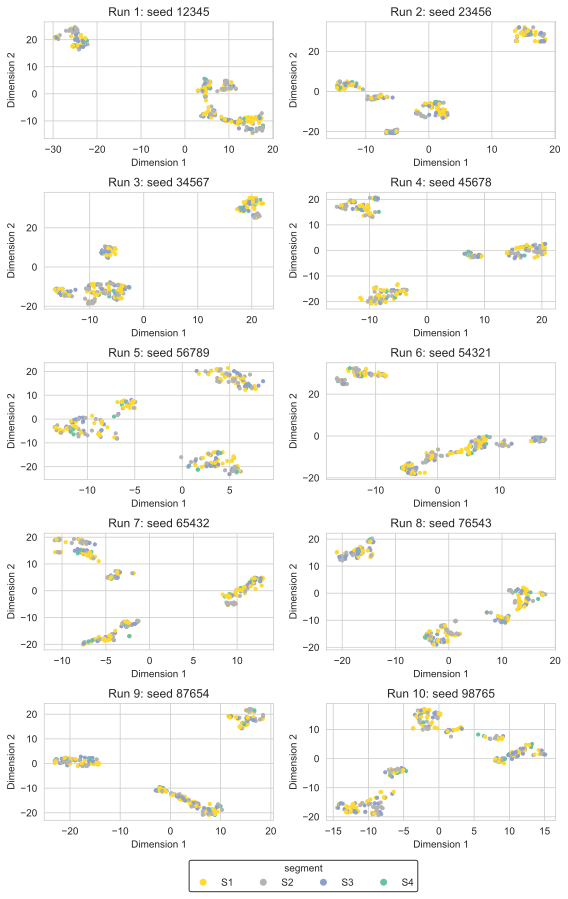

In [24]:
plot_embeddings(mlp_embeddings_1, 'mlp_scatterplots_1', True)

### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10}

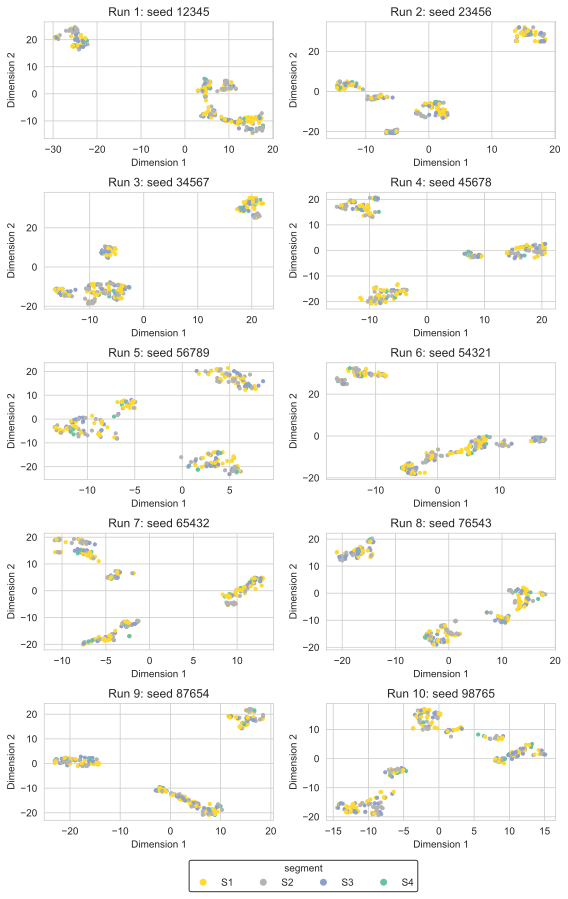

In [25]:
plot_embeddings(mlp_embeddings_2, 'mlp_scatterplots_2', True)

The embeddings learned for the hyperparameter combination with `patience` equal to 5 are identical to the embeddings learned for the hyperparameter combination with `patience` equal to 10.

## Visualization of losses and accuracies

Finally, we take a look at the losses and accuracies in the training set, validation set and test set for the 10 runs for both hyperparameter combinations.

### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 5}

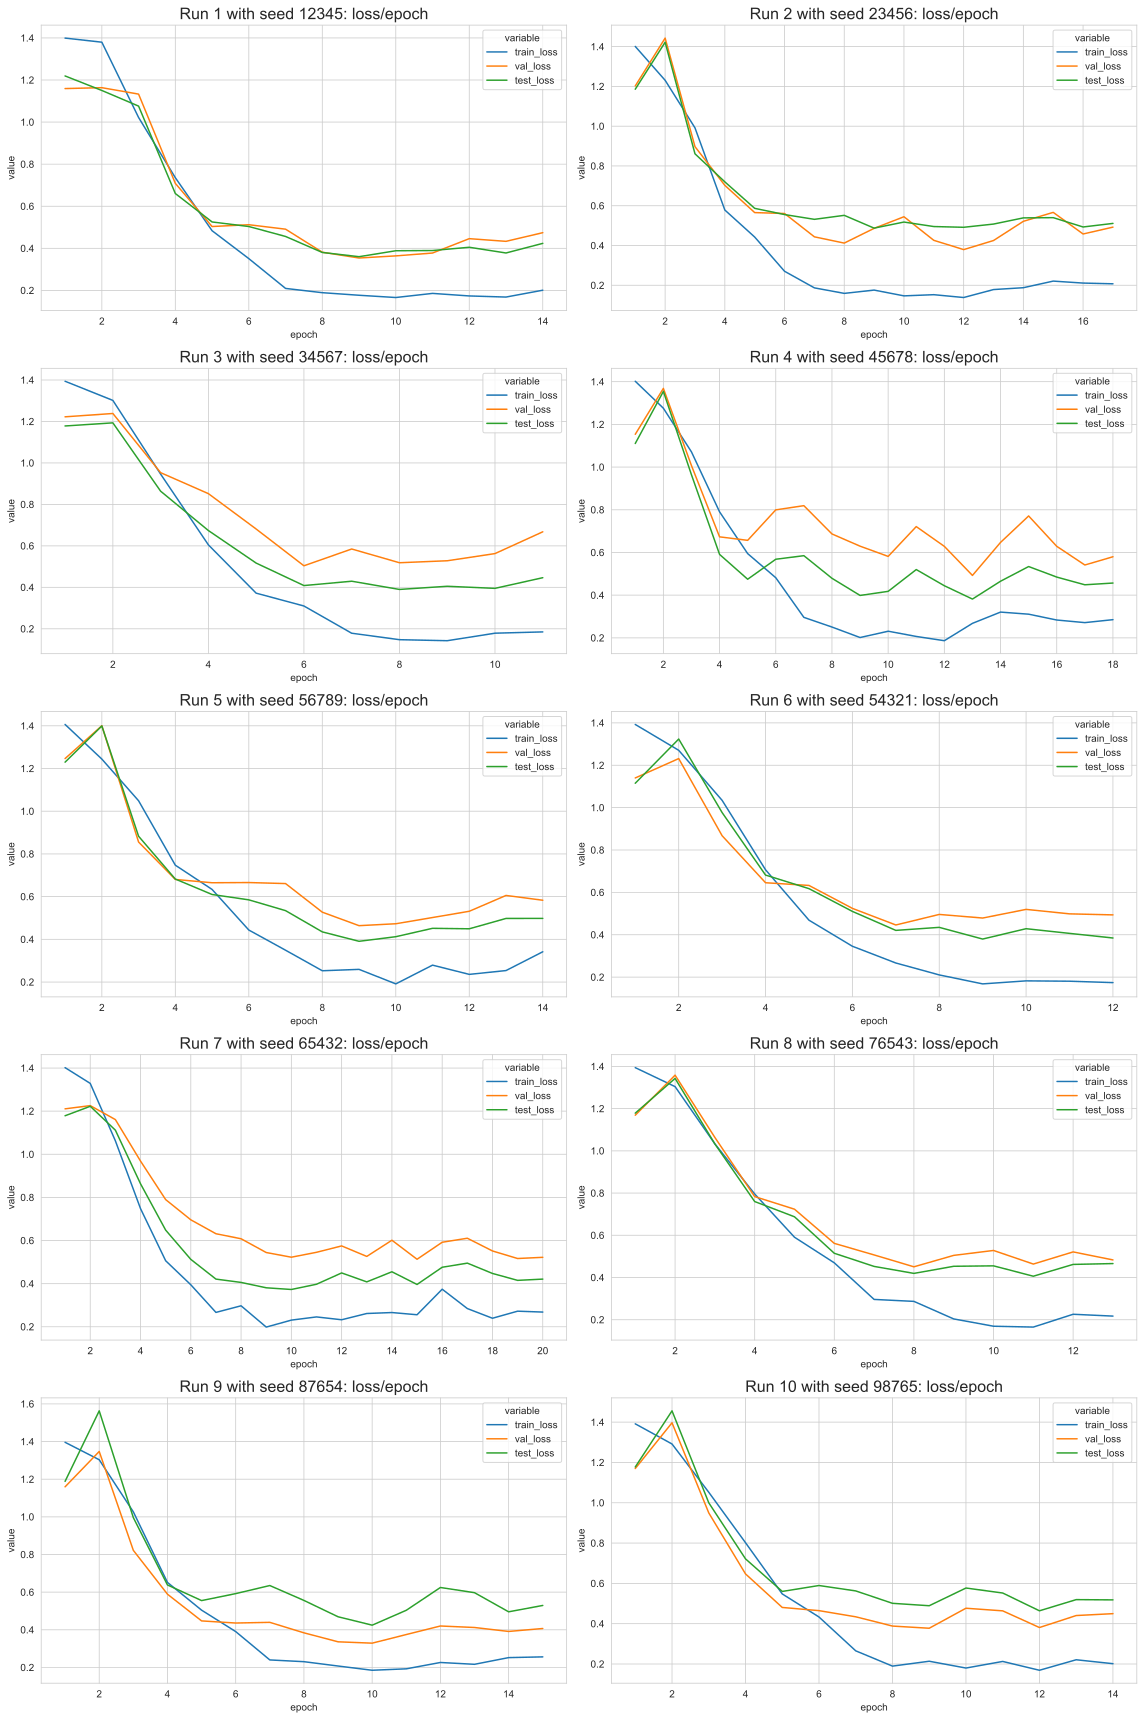

In [32]:
plot_losses_and_accuracies('loss', mlp_results, 472, 2.0, 'mlp_loss_combo_1', True)

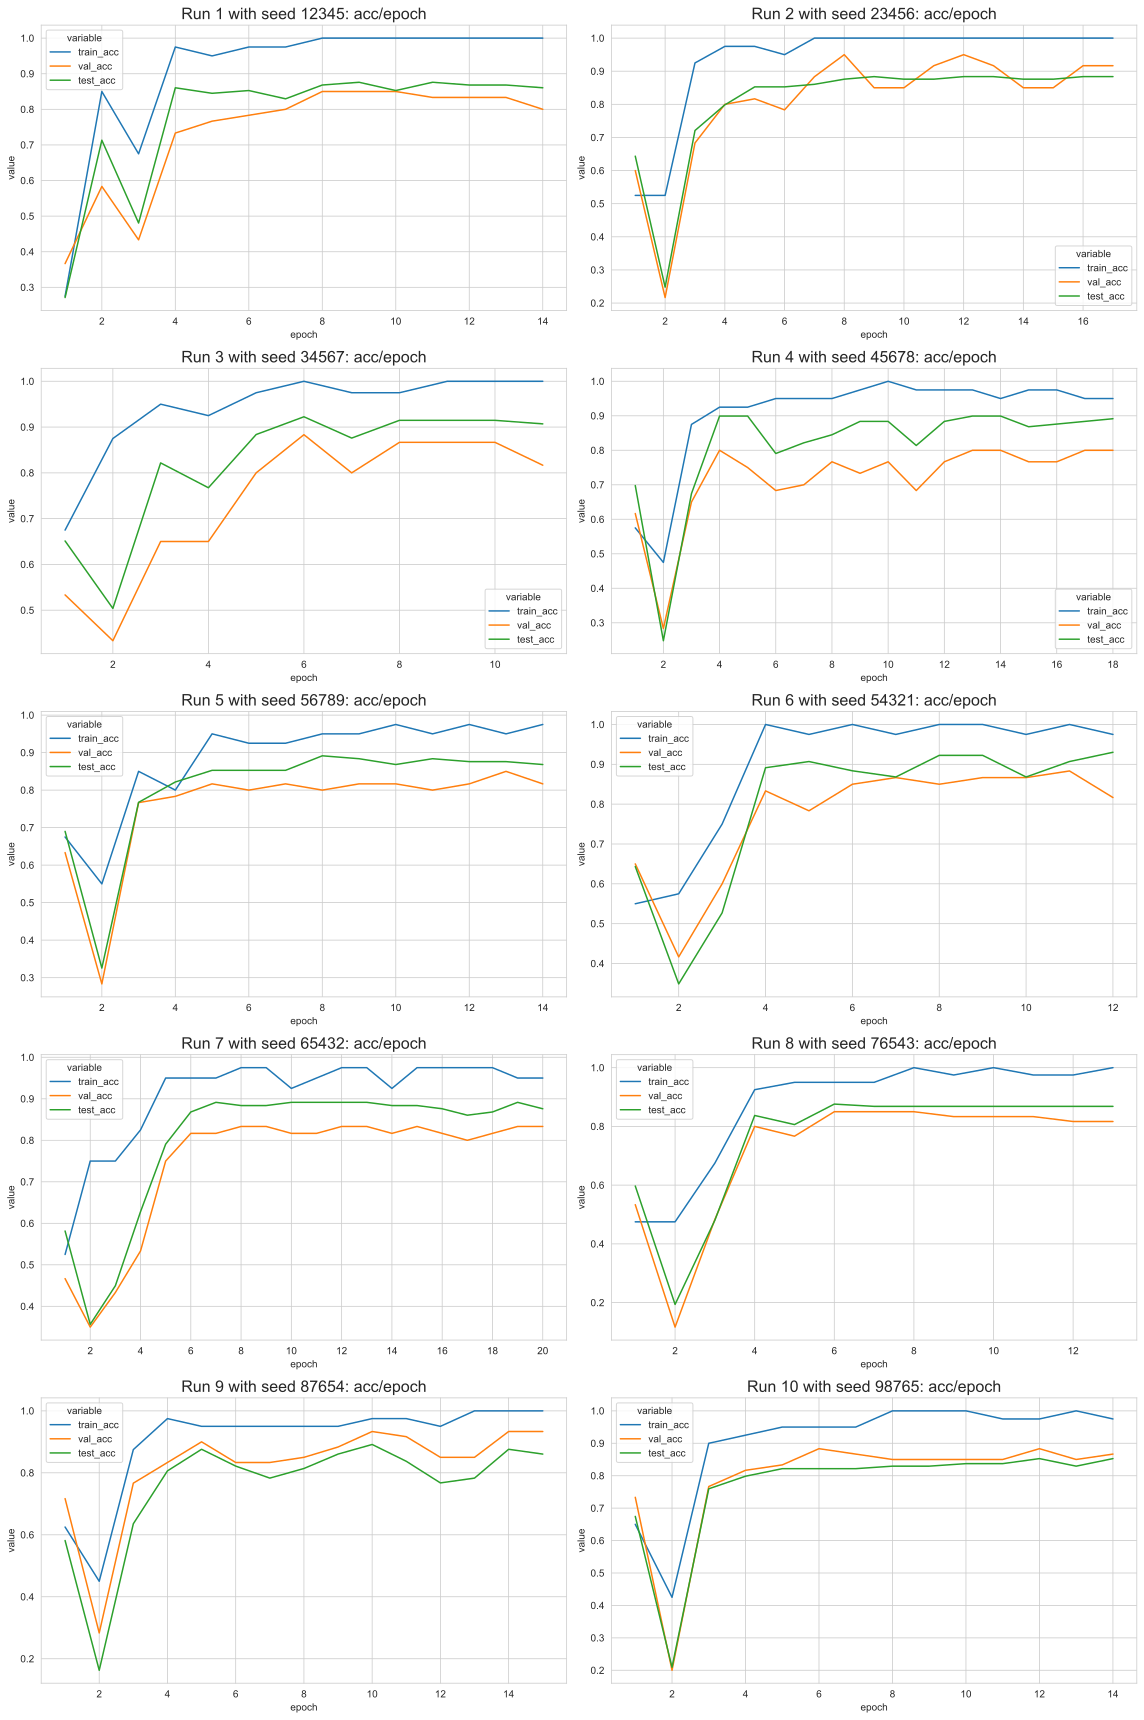

In [27]:
plot_losses_and_accuracies('acc', mlp_results, 472, 2.0, 'mlp_acc_combo_1', True)

### Combination {'hidden_channels': 32, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10}

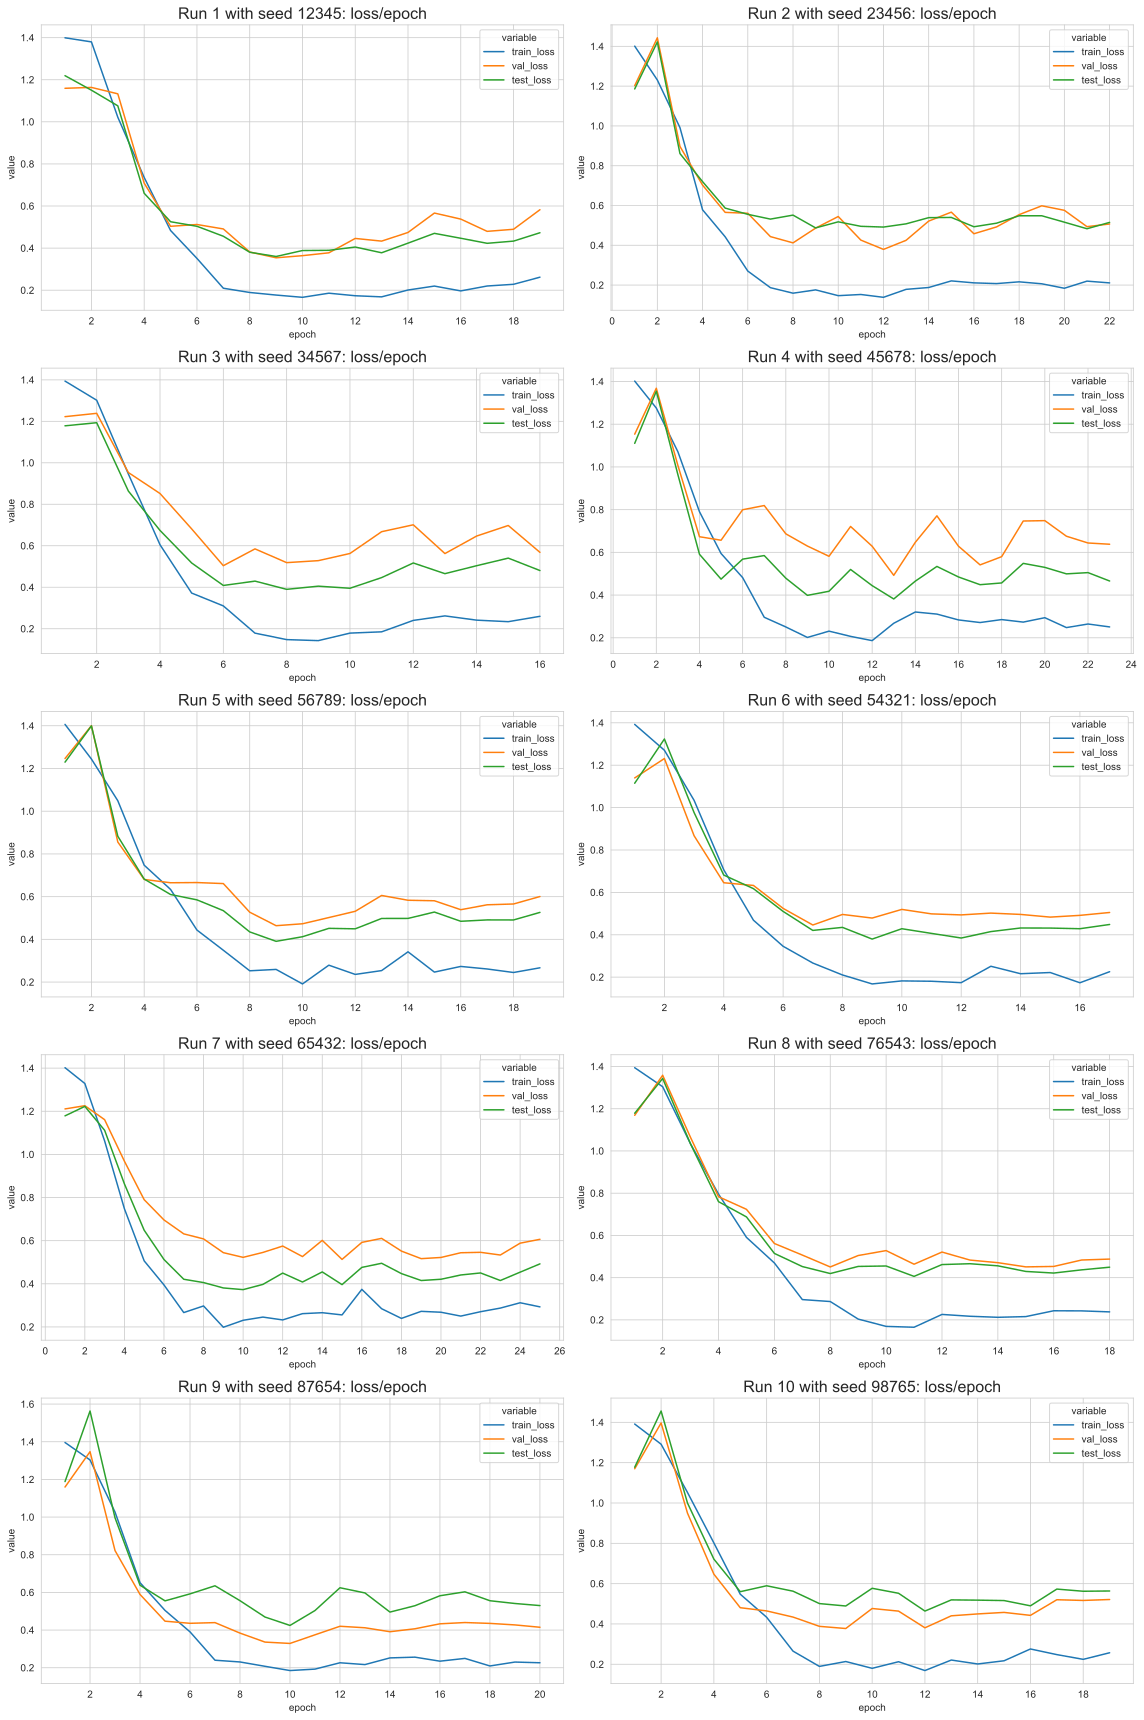

In [33]:
plot_losses_and_accuracies('loss', mlp_results, 473, 2.0, 'mlp_loss_combo_2', True)

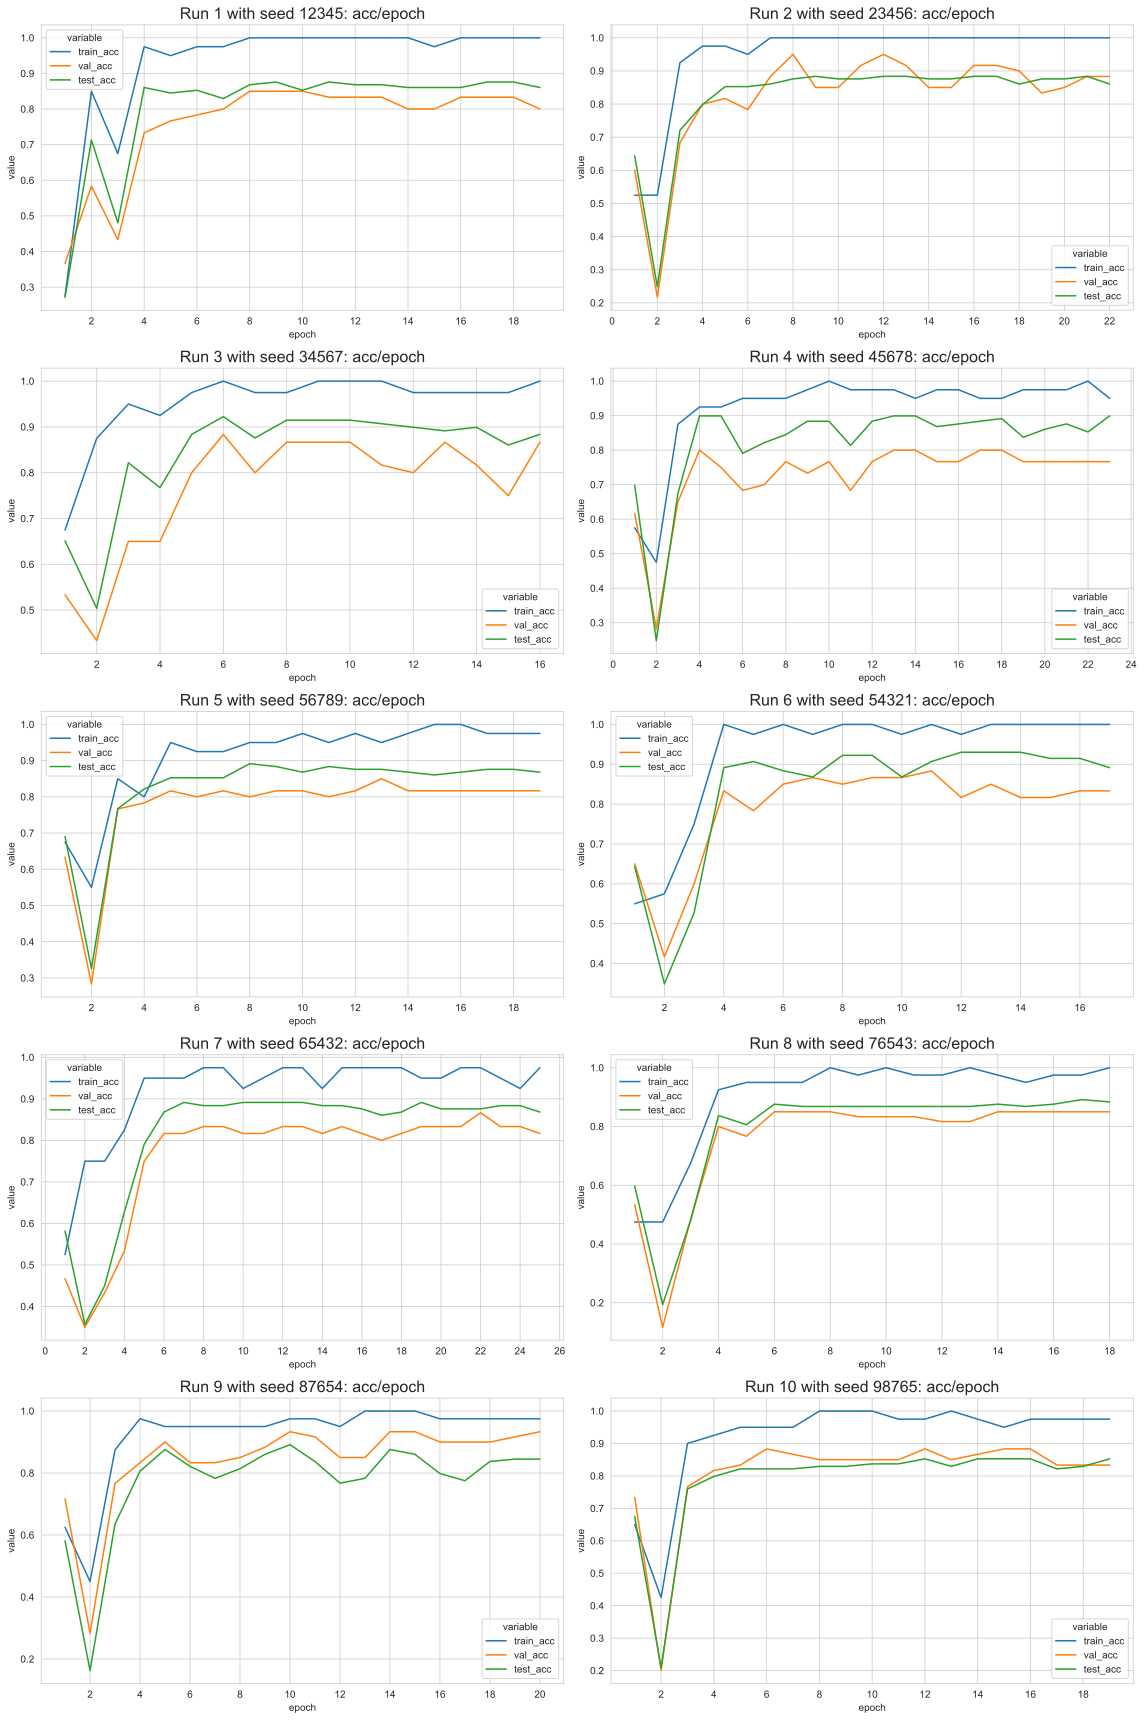

In [29]:
plot_losses_and_accuracies('acc', mlp_results, 473, 2.0, 'mlp_acc_combo_2', True)